>
> # Shared rides with pricing

 ### Changes to:
 * shared.py
 * new function `pool_price.py` (with a debugging logs to see what is happening)
 * used inside `decisions.py\f_match
 * traveller.py (different routine - slightly)
 
 ### Usman choice logic to be applied inside `pool_price.py` 
 (now it is random choice)
 
 ### Tested for Delft, 10 paxes in 10 minutes is enough to debug
 > This notebook was fully working and not thoroughly tested


In [47]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


prepare

In [48]:
from MaaSSim.utils import get_config, load_G, prep_supply_and_demand, generate_demand, generate_vehicles, initialize_df  # simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.simulators import simulate
from MaaSSim.visualizations import plot_veh
from MaaSSim.shared import prep_shared_rides
import logging

In [49]:
import pandas as pd

In [50]:
import ExMAS

In [51]:
params = get_config('../../data/config/delft.json')  # load configuration

In [52]:
params.times.pickup_patience = 3600 # 1 hour of simulation
params.simTime = 0.1 # 6 minutes hour of simulation
params.nP = 8 # reuqests (and passengers)
params.nV = 8 # vehicles

In [53]:
params.t0 = pd.Timestamp.now()
params.shareability.avg_speed = params.speeds.ride
params.shareability.shared_discount = 0.3
params.shareability.delay_value = 1
params.shareability.WtS = 1.3
params.shareability.price = 1.5 #eur/km
params.shareability.VoT = 0.0035 #eur/s
params.shareability.matching_obj = 'u_pax' #minimize VHT for vehicles
params.shareability.pax_delay = 0
params.shareability.horizon = 600
params.shareability.max_degree = 4
params.shareability.nP = params.nP
params.shareability.share = 1
params.shareability.without_matching = True
params.shareability.operating_cost = 0.5
params.shareability.comm_rate = 0.2

In [54]:
inData = load_G(inData, params)  # load network graph 

In [55]:
inData = generate_demand(inData, params, avg_speed = False)
inData.vehicles = generate_vehicles(inData,params.nV)
inData.vehicles.platform = inData.vehicles.apply(lambda x: 0, axis = 1)
inData.passengers.platforms = inData.passengers.apply(lambda x: [0], axis = 1)
inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0], axis = 1) 
inData.platforms = initialize_df(inData.platforms)
inData.platforms.loc[0]=[1,'Uber',30]
params.shareability.share = 1
params.shareability.without_matching = True

In [56]:
inData = ExMAS.main(inData, params.shareability, plot=False) # create shareability graph (ExMAS) 

26-01-23 13:47:12-INFO-Initializing pairwise trip shareability between 8 and 8 trips.
26-01-23 13:47:12-INFO-creating combinations
26-01-23 13:47:12-INFO-56	 nR*(nR-1)
26-01-23 13:47:12-INFO-Reduction of feasible pairs by 92.86%
26-01-23 13:47:12-INFO-Degree 2 	Completed
26-01-23 13:47:12-INFO-trips to extend at degree 2 : 9
26-01-23 13:47:12-INFO-At degree 2 feasible extensions found out of 1 searched
26-01-23 13:47:12-INFO-Degree 3 	Completed
26-01-23 13:47:12-INFO-trips to extend at degree 3 : 1
26-01-23 13:47:13-INFO-At degree 3 feasible extensions found out of 0 searched
26-01-23 13:47:13-INFO-Degree 4 	Completed
26-01-23 13:47:13-INFO-Max degree reached 4
26-01-23 13:47:13-INFO-Trips still possible to extend at degree 4 : 0


In [57]:
inData = prep_shared_rides(inData, params.shareability) # prepare schedules

26-01-23 13:47:14-INFO-Matching 8 trips to 18 rides in order to min u_pax
26-01-23 13:47:14-INFO-Problem solution: Optimal. 
Total costs for single trips:             46 
reduced by matching to:                   43


In [62]:
inData.sblts.rides

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index,...,row,selected,nodes,req_id,sim_schedule,ttrav,dist,fare,commission,driver_revenue
0,[0],6.240500,337,1,[6.2405],"[0, 337]",[0],[0],1,0,...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0,"[None, 2374392592, 1569975455]","[None, 0, 0]",node time req_id od 0 ...,337,3.37,5.06100,1.0122,4.0488
1,[1],5.901500,319,1,[5.9015],"[86, 319]",[1],[1],1,1,...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1,"[None, 44740925, 44822068]","[None, 1, 1]",node time req_id od 0 NaN...,319,3.19,4.78500,0.9570,3.8280
2,[2],6.957500,376,1,[6.9575],"[135, 376]",[2],[2],1,2,...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0,"[None, 2670677180, 2595466387]","[None, 2, 2]",node time req_id od 0 ...,376,3.76,5.64150,1.1283,4.5132
3,[3],2.781000,150,1,[2.7809999999999997],"[136, 150]",[3],[3],1,3,...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",1,"[None, 44813852, 3377240340]","[None, 3, 3]",node time req_id od 0 ...,150,1.50,2.25600,0.4512,1.8048
4,[4],4.369000,236,1,[4.369],"[162, 236]",[4],[4],1,4,...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",0,"[None, 1436427109, 4349049083]","[None, 4, 4]",node time req_id od 0 ...,236,2.36,3.54300,0.7086,2.8344
5,[5],6.038500,326,1,[6.0385],"[164, 326]",[5],[5],1,5,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",0,"[None, 5119770538, 44742832]","[None, 5, 5]",node time req_id od 0 ...,326,3.26,4.89750,0.9795,3.9180
6,[6],5.315500,287,1,[5.3155],"[188, 287]",[6],[6],1,6,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",1,"[None, 1679761149, 1615493771]","[None, 6, 6]",node time req_id od 0 ...,287,2.87,4.31100,0.8622,3.4488
7,[7],8.474500,458,1,[8.4745],"[207, 458]",[7],[7],1,7,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",1,"[None, 549920740, 44786849]","[None, 7, 7]",node time req_id od 0 N...,458,4.58,6.87150,1.3743,5.4972
8,"[0, 5]",10.965850,572,20,"[5.2239249999999995, 5.741924999999999]","[33.5, 97, 239, 236]","[0, 5]","[0, 5]",2,8,...,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",1,"[None, 2374392592, 5119770538, 1569975455, 447...","[None, 0, 5, 0, 5]",node time req_id od 0 ...,572,5.72,6.97095,1.9917,7.9668
9,"[1, 5]",11.728150,736,20,"[5.84745, 5.880699999999999]","[-33.0, 316, 114, 306]","[1, 5]","[1, 5]",2,9,...,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",0,"[None, 44740925, 5119770538, 44822068, 44742832]","[None, 1, 5, 1, 5]",node time req_id od 0 ...,736,7.36,6.77775,1.9365,7.7460


In [66]:
sim = simulate(params = params, inData = inData, logger_level = logging.WARNING) # simulate

26-01-23 13:54:37-WARNING-Setting up 0.1h simulation at 2023-01-26 13:46:27 for 8 vehicles and 8 passengers in Delft, Netherlands
26-01-23 13:54:37-CRITICAL-this is request 0 with [0, 8, 13] available rides.
26-01-23 13:54:37-CRITICAL-ride 0 available [1]
26-01-23 13:54:37-CRITICAL-ride 8 available [1, 0]
26-01-23 13:54:37-CRITICAL-ride 13 available [1, 0]
26-01-23 13:54:37-CRITICAL-this is reuqest 0 with [0, 8, 13] still available rides.
26-01-23 13:54:37-CRITICAL-vehicle 1 has chosen to serve request 0 with a ride 8 of degree 2, with travellers [0, 5].
26-01-23 13:54:37-CRITICAL-this is request 1 with [1, 9] available rides.
26-01-23 13:54:37-CRITICAL-ride 1 available [1]
26-01-23 13:54:37-CRITICAL-ride 9 not available [1, 3]
26-01-23 13:54:37-CRITICAL-this is reuqest 1 with [1] still available rides.
26-01-23 13:54:37-CRITICAL-this is request 2 with [2, 10, 11, 14, 15, 17] available rides.
26-01-23 13:54:37-CRITICAL-ride 2 available [1]
26-01-23 13:54:37-CRITICAL-ride 10 available [

In [14]:
inData.sblts.rides.nodes.to_list()[0][2]



2200558753

In [15]:
dist_to_pick = []
veh_pos = []

In [16]:
sim.pax

{0: <MaaSSim.traveller.PassengerAgent at 0x1dff12c2950>,
 1: <MaaSSim.traveller.PassengerAgent at 0x1dff12336d0>,
 2: <MaaSSim.traveller.PassengerAgent at 0x1dff0e142b0>,
 3: <MaaSSim.traveller.PassengerAgent at 0x1dff0e14a60>,
 4: <MaaSSim.traveller.PassengerAgent at 0x1dff0e15210>,
 5: <MaaSSim.traveller.PassengerAgent at 0x1dff0e159c0>,
 6: <MaaSSim.traveller.PassengerAgent at 0x1dff0e16170>,
 7: <MaaSSim.traveller.PassengerAgent at 0x1dff0e168f0>}

In [17]:
dist_to_pick



[]

In [42]:
dist_to_pick = []
veh_pos = [sim.vehs[i].veh.pos for i in sim.vehs]
for i in range(0, len(inData.sblts.rides.index)):
    pax_pos = inData.sblts.rides.iloc[i].nodes[1]
    dist_to_pi = max([sim.inData.skim[j][pax_pos] for j in veh_pos])/1000
    dist_to_pick.append(dist_to_pi)
inData.sblts.rides["dist_to_pick"] = dist_to_pick
inData.sblts.rides["total_dist"] = inData.sblts.rides["dist_to_pick"] + inData.sblts.rides["dist"]
#fuel = 1.5
price = 0.5 
penalty = 1
inData.sblts.rides["cost"] = inData.sblts.rides["dist_to_pick"].apply(lambda x : x*price)
inData.sblts.rides["profit"] = inData.sblts.rides["driver_revenue"] - inData.sblts.rides["cost"]

#inData.sblts.rides["all_cost"] =  inData.sblts.rides["cost"].apply(lambda x : x + penalty) # time and fuel are left

In [46]:
inData.sblts.rides

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index,...,ttrav,dist,fare,commission,driver_revenue,dist_to_pick,total_dist,cost,profit,all_cost
0,[0],8.274000,447,1,[8.274000000000001],"[0, 447]",[0],[0],1,0,...,447,4.47,6.7095,1.3419,5.3676,4.473,8.943,2.2365,3.1311,3.2365
1,[1],4.588000,248,1,[4.588],"[0, 248]",[1],[1],1,1,...,248,2.48,3.7200,0.7440,2.9760,3.556,6.036,1.7780,1.1980,2.7780
2,[2],5.690000,307,1,[5.6899999999999995],"[4, 307]",[2],[2],1,2,...,307,3.07,4.6155,0.9231,3.6924,6.121,9.191,3.0605,0.6319,4.0605
3,[3],1.694000,91,1,[1.694],"[10, 91]",[3],[3],1,3,...,91,0.91,1.3755,0.2751,1.1004,4.359,5.269,2.1795,-1.0791,3.1795
4,[4],7.059000,381,1,[7.059],"[19, 381]",[4],[4],1,4,...,381,3.81,5.7255,1.1451,4.5804,5.687,9.497,2.8435,1.7369,3.8435
5,[5],6.928000,374,1,[6.928],"[133, 374]",[5],[5],1,5,...,374,3.74,5.6190,1.1238,4.4952,5.718,9.458,2.8590,1.6362,3.8590
6,[6],4.079000,220,1,[4.079000000000001],"[163, 220]",[6],[6],1,6,...,220,2.20,3.3090,0.6618,2.6472,4.239,6.439,2.1195,0.5277,3.1195
7,[7],2.056500,111,1,[2.0564999999999998],"[243, 111]",[7],[7],1,7,...,111,1.11,1.6680,0.3336,1.3344,4.187,5.297,2.0935,-0.7591,3.0935
8,"[2, 0]",12.923400,747,20,"[5.207825, 7.715575]","[-83.5, 171, 176, 400]","[2, 0]","[2, 0]",2,8,...,747,7.47,11.3250,2.2650,9.0600,6.121,13.591,3.0605,5.9995,4.0605
9,"[2, 5]",11.149950,609,20,"[5.032649999999999, 6.117299999999999]","[4.0, 129, 267, 213]","[2, 5]","[2, 5]",2,9,...,609,6.09,10.2345,2.0469,8.1876,6.121,12.211,3.0605,5.1271,4.0605


In [45]:
sim = simulate(params = params, inData = inData, logger_level = logging.WARNING) # simulate

26-01-23 12:44:31-WARNING-Setting up 0.1h simulation at 2023-01-26 12:24:25 for 8 vehicles and 8 passengers in Delft, Netherlands
26-01-23 12:44:31-CRITICAL-this is request 0 with [0, 8, 12, 13, 16] available rides.
26-01-23 12:44:31-CRITICAL-ride 0 available [1]
26-01-23 12:44:31-CRITICAL-ride 8 available [0, 1]
26-01-23 12:44:31-CRITICAL-ride 12 available [0, 1]
26-01-23 12:44:31-CRITICAL-ride 13 available [1, 0]
26-01-23 12:44:31-CRITICAL-ride 16 available [0, 1, 0]
26-01-23 12:44:31-CRITICAL-this is reuqest 0 with [0, 8, 12, 13, 16] still available rides.
44848435
44884491
44865433
44848435
44884491
26-01-23 12:44:31-CRITICAL-vehicle 2 has chosen to serve request 0 with a ride 16 of degree 3, with travellers [2, 0, 6].
26-01-23 12:44:31-CRITICAL-this is request 2 with [2, 8, 9, 10, 14, 16] available rides.
26-01-23 12:44:31-CRITICAL-ride 2 available [1]
26-01-23 12:44:31-CRITICAL-ride 8 not available [1, 2]
26-01-23 12:44:31-CRITICAL-ride 9 available [1, 0]
26-01-23 12:44:31-CRITIC

In [36]:
my_choice = inData.sblts.rides[inData.sblts.rides["profit"]==inData.sblts.rides["profit"].max()].squeeze()

In [37]:
my_choice

indexes                                                    [2, 0, 6]
u_pax                                                      16.247525
u_veh                                                            865
kind                                                              32
u_paxes                     [5.0440249999999995, 7.856625, 3.346875]
times                                [-83.5, 171, 200, 23, 196, 275]
indexes_orig                                               [2, 0, 6]
indexes_dest                                               [2, 6, 0]
degree                                                             3
index                                                             16
PassHourTrav_ns                                                  974
row                         [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
selected                                                           0
nodes              [None, 44884491, 44848435, 44810830, 523533721...
req_id                            

In [38]:
inData.sblts.rides.keys()

Index(['indexes', 'u_pax', 'u_veh', 'kind', 'u_paxes', 'times', 'indexes_orig',
       'indexes_dest', 'degree', 'index', 'PassHourTrav_ns', 'row', 'selected',
       'nodes', 'req_id', 'sim_schedule', 'ttrav', 'dist', 'fare',
       'commission', 'driver_revenue', 'dist_to_pick', 'total_dist', 'cost',
       'profit'],
      dtype='object')

simulate

In [44]:
sim = simulate(params = params, inData = inData, logger_level = logging.WARNING) # simulate

26-01-23 12:44:07-WARNING-Setting up 0.1h simulation at 2023-01-26 12:24:25 for 8 vehicles and 8 passengers in Delft, Netherlands
26-01-23 12:44:07-CRITICAL-this is request 0 with [0, 8, 12, 13, 16] available rides.
26-01-23 12:44:07-CRITICAL-ride 0 available [1]
26-01-23 12:44:07-CRITICAL-ride 8 available [0, 1]
26-01-23 12:44:07-CRITICAL-ride 12 available [0, 1]
26-01-23 12:44:07-CRITICAL-ride 13 available [1, 0]
26-01-23 12:44:07-CRITICAL-ride 16 available [0, 1, 0]
26-01-23 12:44:07-CRITICAL-this is reuqest 0 with [0, 8, 12, 13, 16] still available rides.
44848435
44884491
44865433
44848435
44884491
26-01-23 12:44:07-CRITICAL-vehicle 2 has chosen to serve request 0 with a ride 16 of degree 3, with travellers [2, 0, 6].
26-01-23 12:44:07-CRITICAL-this is request 2 with [2, 8, 9, 10, 14, 16] available rides.
26-01-23 12:44:07-CRITICAL-ride 2 available [1]
26-01-23 12:44:07-CRITICAL-ride 8 not available [1, 2]
26-01-23 12:44:07-CRITICAL-ride 9 available [1, 0]
26-01-23 12:44:07-CRITIC

In [74]:
pd.DataFrame(sim.vehs[3].myrides)

,veh,pos,t,event,paxes
0,3,4.244384e+09,0.0,STARTS_DAY,[]
1,3,4.244384e+09,0.0,OPENS_APP,[]
2,3,4.244384e+09,81.0,RECEIVES_REQUEST,[]
3,3,4.244384e+09,96.0,ACCEPTS_REQUEST,[]
4,3,4.244384e+09,116.0,IS_ACCEPTED_BY_TRAVELLER,[]
5,3,4.349049e+09,169.0,ARRIVES_AT_PICKUP,[]
6,3,4.349049e+09,169.0,MEETS_TRAVELLER_AT_PICKUP,[]
7,3,4.349049e+09,199.0,DEPARTS_FROM_PICKUP,[4]
8,3,2.857436e+08,495.0,ARRIVES_AT_DROPOFF,[4]
9,3,2.857436e+08,7559.0,ENDS_SHIFT,[]


In [48]:
sim.inData.requests.position

pax
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
Name: position, dtype: int64

In [49]:
df = sim.runs[0].rides
df[df.veh==1]

,veh,pos,t,event,paxes
0,1,4.473961e+07,0.0,STARTS_DAY,[]
1,1,4.473961e+07,0.0,OPENS_APP,[]
2,1,4.473961e+07,0.0,RECEIVES_REQUEST,[]
3,1,4.473961e+07,15.0,ACCEPTS_REQUEST,[]
4,1,4.473961e+07,35.0,IS_ACCEPTED_BY_TRAVELLER,[]
5,1,1.608998e+09,257.0,ARRIVES_AT_PICKUP,[]
6,1,1.608998e+09,257.0,MEETS_TRAVELLER_AT_PICKUP,[]
7,1,1.608998e+09,287.0,DEPARTS_FROM_PICKUP,[0]
8,1,4.473961e+07,527.0,ARRIVES_AT_DROPOFF,[0]
9,1,4.473961e+07,7559.0,ENDS_SHIFT,[]


In [50]:
trips = sim.runs[0].trips
trips[trips.pax==8]

,pax,pos,t,event,veh_id


In [51]:
trips[trips.pax==0]

,pax,pos,t,event,veh_id
0,0,1608998197,0,STARTS_DAY,NaN
1,0,1608998197,0,REQUESTS_RIDE,NaN
2,0,1608998197,0,RECEIVES_OFFER,NaN
3,0,1608998197,15,ACCEPTS_OFFER,NaN
4,0,1608998197,35,ARRIVES_AT_PICKUP,1.0
5,0,1608998197,257,MEETS_DRIVER_AT_PICKUP,1.0
6,0,1608998197,287,DEPARTS_FROM_PICKUP,1.0
7,0,44739609,527,ARRIVES_AT_DROPOFF,1.0
8,0,44739609,537,SETS_OFF_FOR_DEST,NaN
9,0,44739609,537,ARRIVES_AT_DEST,NaN


In [52]:
df[df.veh==1]

,veh,pos,t,event,paxes
0,1,4.473961e+07,0.0,STARTS_DAY,[]
1,1,4.473961e+07,0.0,OPENS_APP,[]
2,1,4.473961e+07,0.0,RECEIVES_REQUEST,[]
3,1,4.473961e+07,15.0,ACCEPTS_REQUEST,[]
4,1,4.473961e+07,35.0,IS_ACCEPTED_BY_TRAVELLER,[]
5,1,1.608998e+09,257.0,ARRIVES_AT_PICKUP,[]
6,1,1.608998e+09,257.0,MEETS_TRAVELLER_AT_PICKUP,[]
7,1,1.608998e+09,287.0,DEPARTS_FROM_PICKUP,[0]
8,1,4.473961e+07,527.0,ARRIVES_AT_DROPOFF,[0]
9,1,4.473961e+07,7559.0,ENDS_SHIFT,[]


<AxesSubplot:>

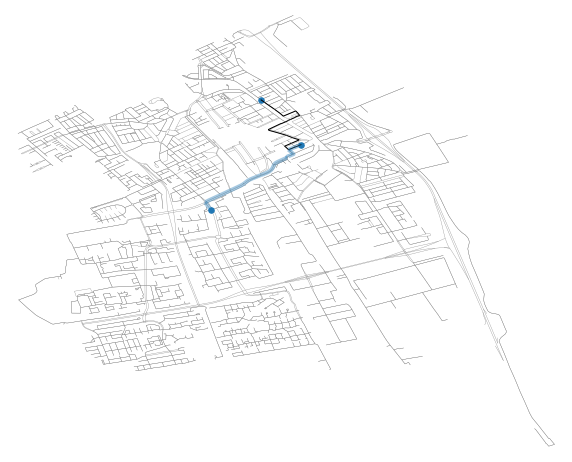

In [53]:
for i in range(params.nV):
    paxes = df[df.veh==i].paxes
    if paxes.apply(lambda x: len(x)).max()>1:
        break
plot_veh(inData.G, df[df.veh ==2], lw = 1)

-----